In [30]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [31]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

In [32]:
df_avis_up = pd.read_csv("../data/avis_clean.csv")

# II. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [65]:
jeux_cat = df_jeux_up.apply(traitement.extract_categories, axis=1)

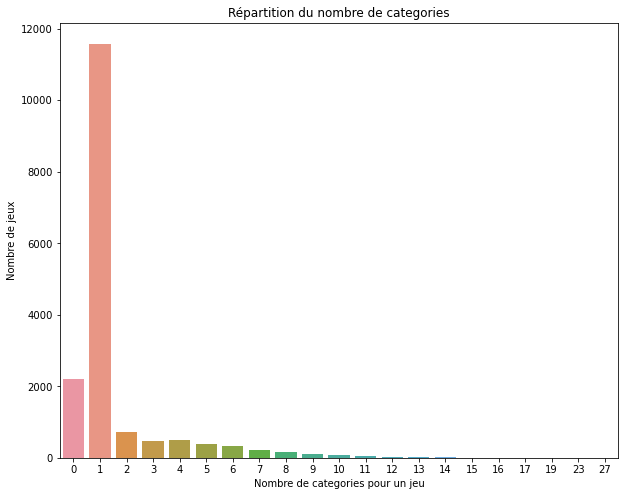

In [66]:
val, count = np.unique(jeux_cat.map(len), return_counts=True)
index = count.argsort()[::-1]
count = count[index]
val = val[index]

plt.figure(figsize=(10, 8))
sns.barplot(val, count)
plt.xlabel("Nombre de categories pour un jeu")
plt.ylabel("Nombre de jeux")
plt.title("Répartition du nombre de categories")
plt.show()

In [67]:
count[val == 0].sum() / len(jeux_cat)

0.13026729093818526

In [68]:
count[val == 1].sum() / len(jeux_cat)

0.6863628281870444

In [69]:
count[val > 1].sum() / len(jeux_cat)

0.18336988087477035

- Les majorités des jeux ont qu'une seule catégorie (68% des jeux), et environ 13% de jeux n'ont pas de catégories. 
- 18% ont plus d'une catégorie.

Avoir plusieurs catégories pour un jeu peut être dérangeant, pour des problèmes de classification entre autres.

In [70]:
cats = []
jeux_cat.map(cats.extend)
u_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
u_cats     = u_cats[index]

In [71]:
print(f"{len(u_cats)} tag de categories")

184 tag de categories


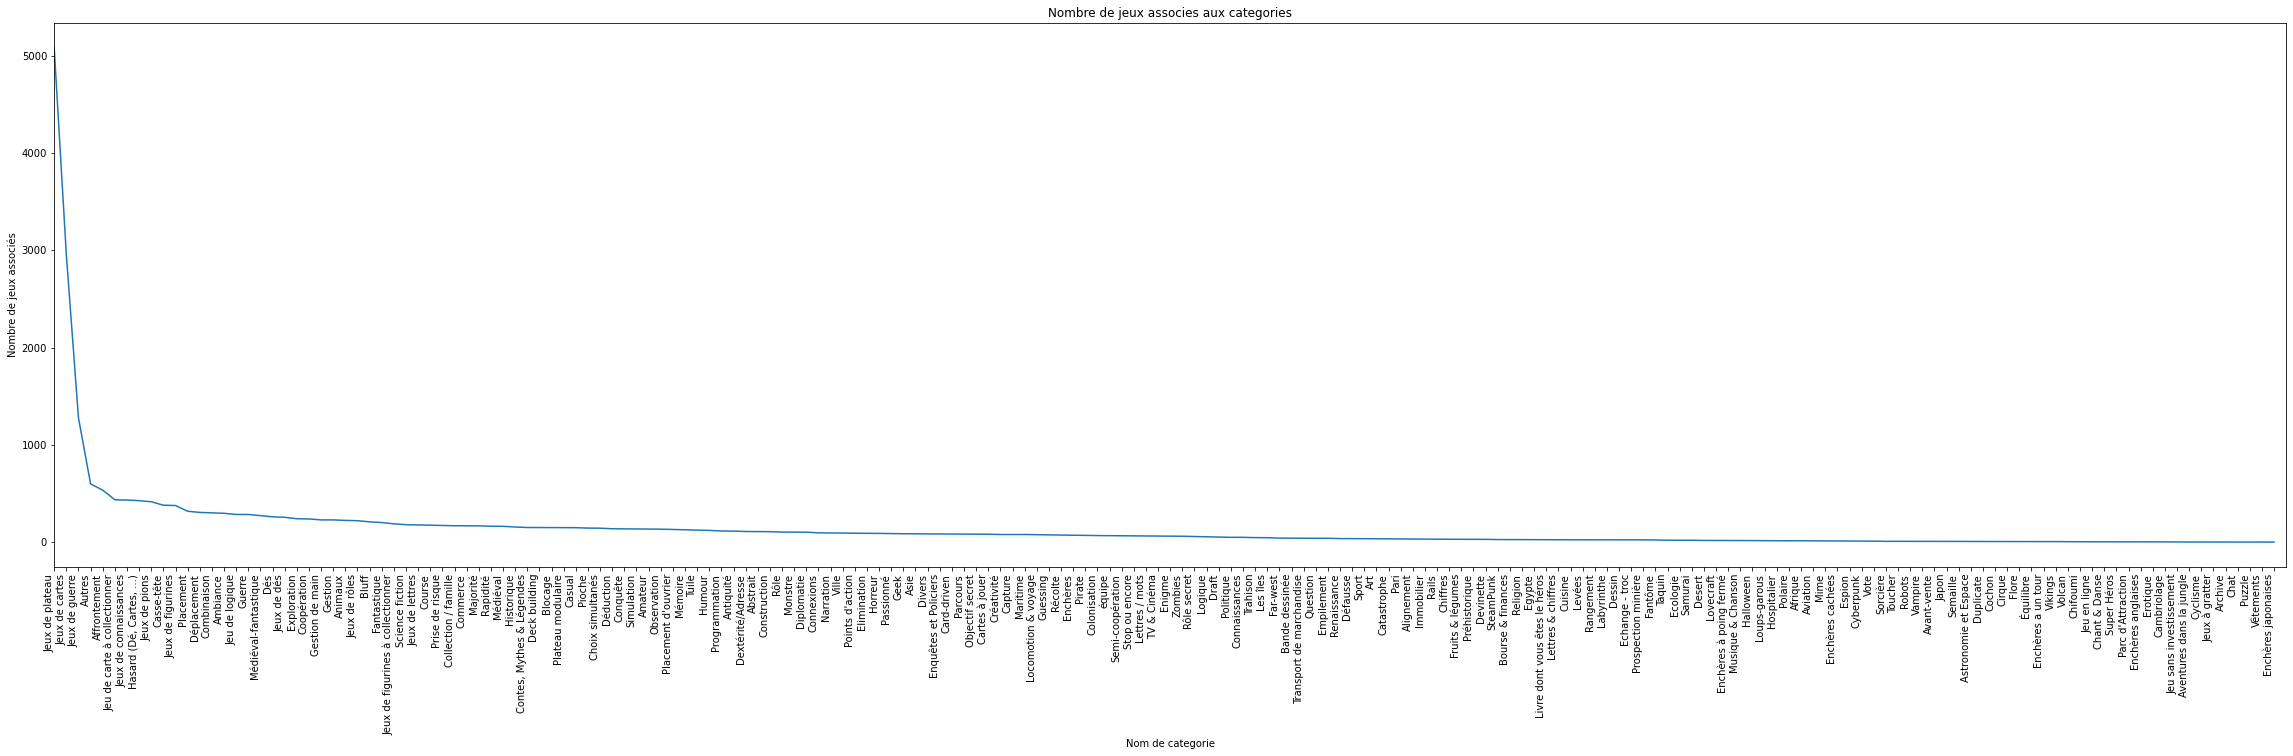

In [72]:
plt.figure(figsize=(40, 10))
plt.plot(u_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(u_cats)))
plt.show()

### 1. Nettoyer les catégories : 

In [73]:
c_cats = []

for cat in u_cats:
    cat_ = preprocessing.clean_text(cat)
    cat_tokens = preprocessing.tokenize_text(cat_)    
    cat_tokens = preprocessing.remove_stopwords(cat_tokens)
    cat_tokens = preprocessing.lemmatize_tokens(cat_tokens)
    cat_ = " ".join(cat_tokens)
    c_cats.append(cat_)

In [74]:
u = np.unique(c_cats)
print(f"Apres nettoyage on a {len(np.delete(u, np.where(u == '')))} tag de categorie")

Apres nettoyage on a 173 tag de categorie


#### Mise à jour des categories des jeux

In [165]:
jeux_cat_up = jeux_cat.copy()

for i, row in jeux_cat.iteritems():
    row_ = []
    
    for cat in row:
        index = np.where(u_cats == cat)[0][0]
        row_.append(c_cats[index])
        
    jeux_cat_up[i] = np.unique(row_)

In [166]:
cats = []
jeux_cat_up.map(cats.extend)

# Supprimer les "" (categories vide apres nlp)
cats = list(filter(("").__ne__, cats))

uc_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
uc_cats    = uc_cats[index]

### 2. Sélection des N catégories principales : 

On va pondérer les catégories par leur log proba d'apparition pour estimer leur importance, et ainsi sélectionner que les principales.

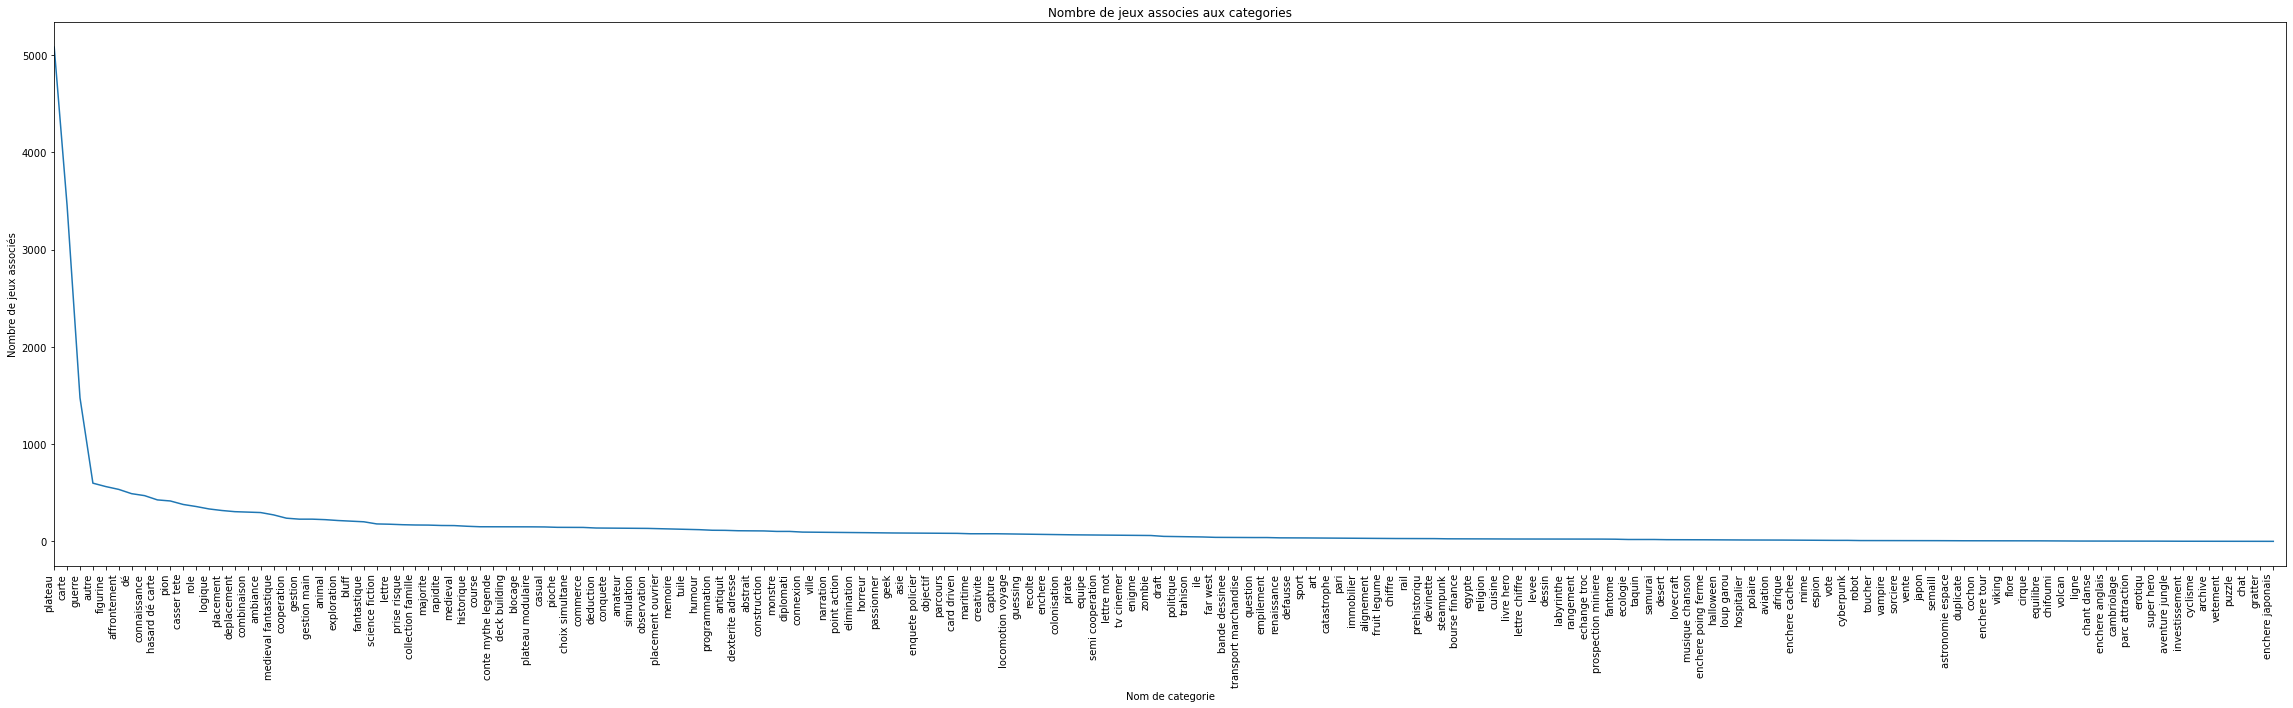

In [167]:
plt.figure(figsize=(40, 10))
plt.plot(uc_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(uc_cats)))
plt.show()

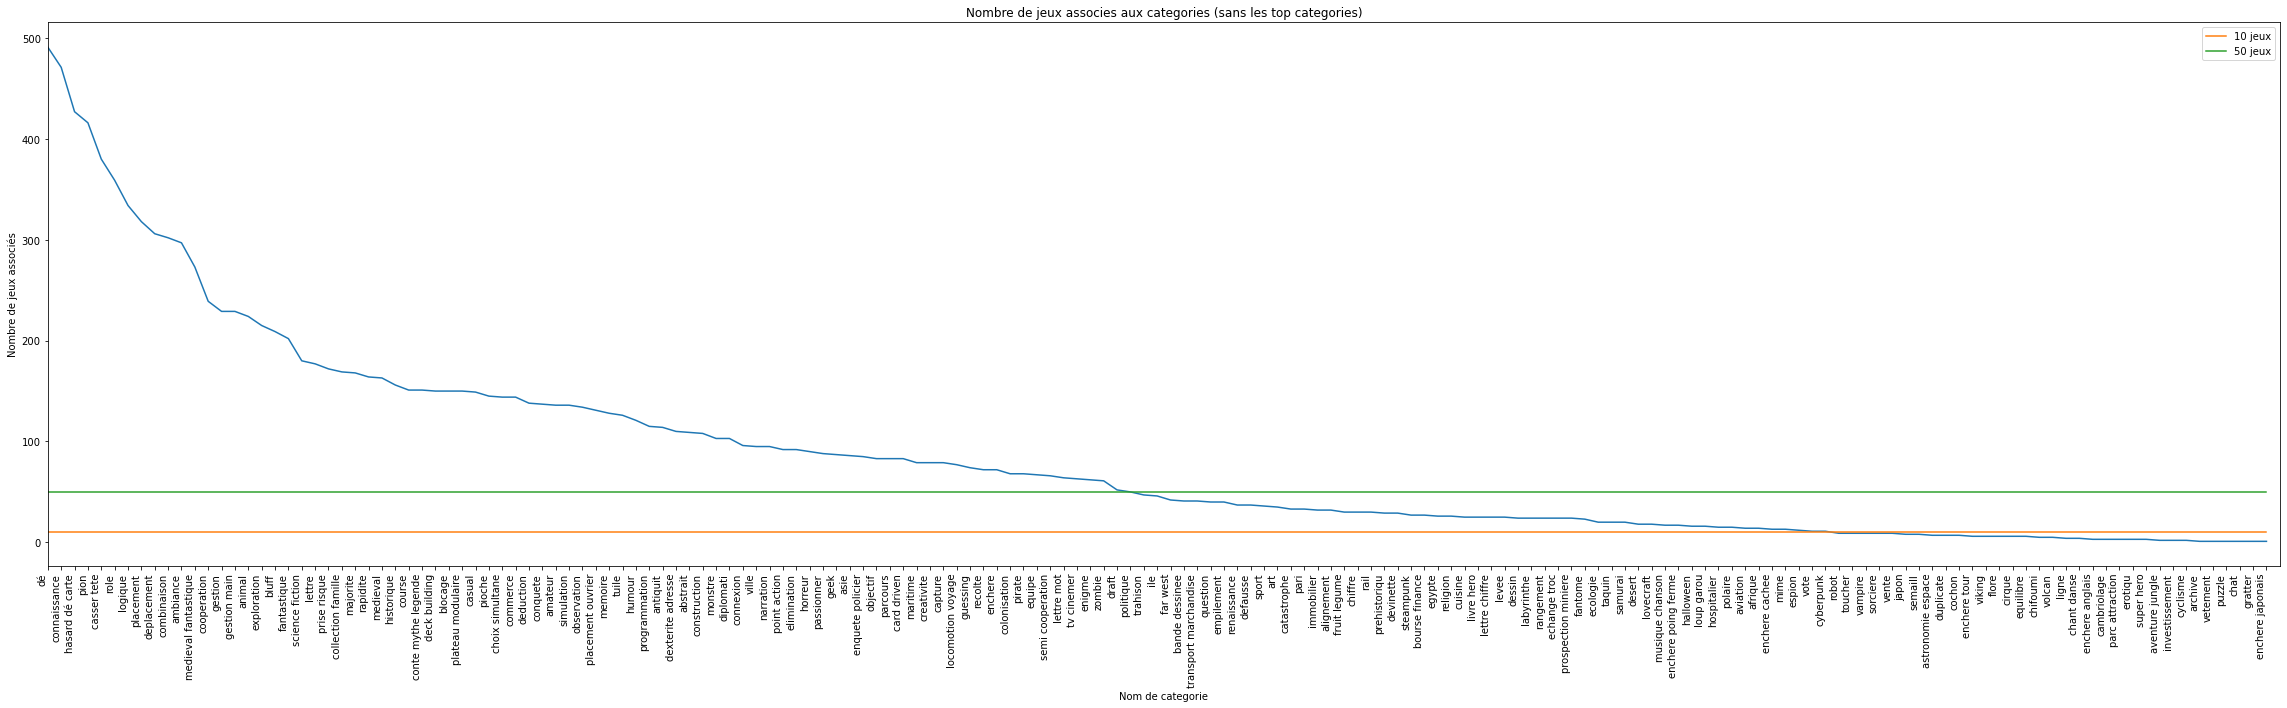

In [168]:
index = count_cats < 500
plt.figure(figsize=(40, 10))
plt.plot(uc_cats[index], count_cats[index])
plt.plot(np.full(len(uc_cats[index]), 10), label="10 jeux")
plt.plot(np.full(len(uc_cats[index]), 50), label="50 jeux")
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories (sans les top categories)")
plt.xlim((0, len(uc_cats[index])))
plt.legend()
plt.show()

In [303]:
p_C_J = []
jeux_cat_up.map(lambda l : np.isin(uc_cats, l).astype(int).tolist()).map(p_C_J.append)
p_C_J = np.array(p_C_J)
p_C_J = p_C_J / p_C_J.sum()
p_C_J.shape

(16873, 173)

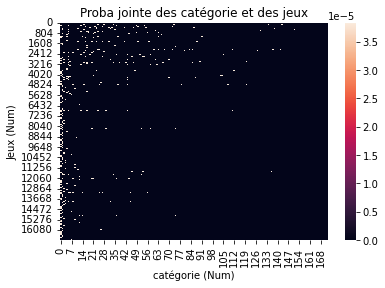

In [304]:
sns.heatmap(p_C_J)
plt.xlabel("catégorie (Num)")
plt.ylabel("Jeux (Num)")
plt.title('Proba jointe des catégorie et des jeux')
plt.show()

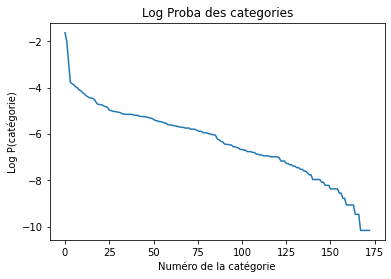

In [305]:
p_cat = p_C_J.sum(axis=0) 
plt.plot(np.log(p_cat))
plt.xlabel("Numéro de la catégorie")
plt.ylabel("Log P(catégorie)")
plt.title("Log Proba des categories")
plt.show()

In [306]:
I = []
jeux_cat_up.map(lambda l : (np.isin(uc_cats, l).astype(int) / (len(l) if len(l) != 0 else 1)).tolist()).map(I.append)
I = np.array(I)
I.shape

(16873, 173)

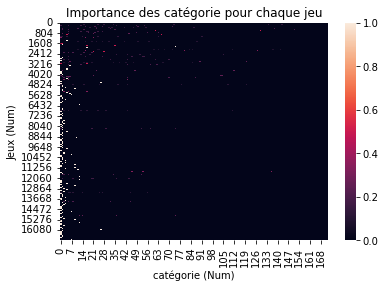

In [307]:
sns.heatmap(I)
plt.xlabel("catégorie (Num)")
plt.ylabel("Jeux (Num)")
plt.title('Importance des catégorie pour chaque jeu')
plt.show()

Soit I une mesure d'importance donné sous cette forme :

$$I(cat_i) = \frac{\sum_j\frac{Q_j(i)}{\lvert L_j \rvert}}{P(cat_i)} \ \ avec \ Q_j(i) = 1 \ si \ cat_i \in L_j$$

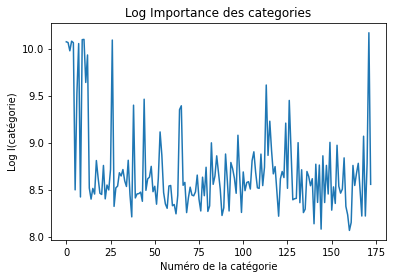

In [313]:
I_cat = I.sum(axis=0) / p_cat
plt.plot(np.log(I_cat))
plt.xlabel("Numéro de la catégorie")
plt.ylabel("Log I(catégorie)")
plt.title("Log Importance des categories")
plt.show()

### TODO : Seuillage ? pour séléctionner les N (remplacer les drop par `autre`)

### 3. Clustering : 

In [380]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(uc_cats)
n_clusters = 150

In [436]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", random_state=0)
kmeans.fit(X)

for i in range(n_clusters):
    print(f"Cluster {i}:")
    for category in np.array(uc_cats)[kmeans.labels_ == i]:
        print(f"\t{category}")

Cluster 0:
	casser tete
	locomotion voyage
	prospection miniere
	erotiqu
Cluster 1:
	lettre
	lettre mot
Cluster 2:
	connaissance
	abstrait
	point action
	creativite
	pari
	rangement
Cluster 3:
	enchere
	enchere poing ferme
	enchere cachee
	enchere tour
	enchere anglais
	enchere japonais
Cluster 4:
	livre hero
	super hero
Cluster 5:
	placement
	placement ouvrier
Cluster 6:
	logique
Cluster 7:
	sport
Cluster 8:
	plateau
	plateau modulaire
Cluster 9:
	observation
Cluster 10:
	asie
Cluster 11:
	medieval fantastique
	medieval
Cluster 12:
	labyrinthe
Cluster 13:
	bluff
Cluster 14:
	tv cinemer
Cluster 15:
	animal
Cluster 16:
	vente
Cluster 17:
	aviation
Cluster 18:
	cyclisme
Cluster 19:
	gestion
	gestion main
Cluster 20:
	colonisation
Cluster 21:
	cirque
Cluster 22:
	horreur
Cluster 23:
	equipe
Cluster 24:
	zombie
Cluster 25:
	humour
Cluster 26:
	carte
	dé
	hasard dé carte
Cluster 27:
	chiffre
	lettre chiffre
Cluster 28:
	halloween
Cluster 29:
	viking
Cluster 30:
	fruit legume
Cluster 31:
	ma

## Résultat intéressant ! TODO

- Ajouter quelques mots dans le sw pour affiner et sélectionner les catégories les plus importantes pourrait vraiment donner de (très) bons résultats.